In [1]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools
import grid_tools

import cartopy
import cartopy.crs as ccrs

import scipy.io as sio

In [2]:
matdata = sio.loadmat('data/o2trend_1970_2010_400m.mat',squeeze_me=True)
for k in matdata.keys():
    if '__' in k: continue
    print k
    try:
        print matdata[k].shape
    except:
        print k

    print

R2le
(34,)

suff
(34,)

SEcore
SEcore

TRcore
TRcore

trend1core
(360, 180)

TRobs
TRobs

trend1obs
(360, 180)

STNAo2obs
(40,)

trend1le
(360, 180, 34)

SEle
(34,)

STNAo2le
(40, 34)

tval95le
(34,)

tval95obs
tval95obs

TRle
(34,)

R2obs
R2obs

R2core
R2core

STNAo2core
(40,)

SEobs
SEobs

tval95core
tval95core



In [3]:
time = xr.DataArray(np.arange(1970.5,2010.5,1),dims=('time'),coords={'time':np.arange(1970.5,2010.5,1)})

cesm_o2 = xr.DataArray(matdata['STNAo2le'],dims=('time','ens'),
                       coords={'time':time})
trle = xr.DataArray(matdata['TRle'],dims=('ens'))

trobs = matdata['TRobs']
seobs = matdata['SEobs']

obs_o2 = xr.DataArray(matdata['STNAo2obs'],dims=('time'),coords={'time':time})
obs = xr.Dataset({'o2':obs_o2})
print obs

<xarray.Dataset>
Dimensions:  (time: 40)
Coordinates:
  * time     (time) float64 1.97e+03 1.972e+03 1.972e+03 1.974e+03 1.974e+03 ...
Data variables:
    o2       (time) float64 2.701 0.2846 2.974 3.184 -0.4485 1.373 -0.01716 ...


In [4]:
I = np.where(trle<np.percentile(trle,10))[0]
I

array([ 9, 10, 29, 30])

In [5]:
nx = 360
ny = 180
grid = grid_tools.generate_latlon_grid(nx=nx,ny=ny,lon0=0.)
#grid['lon'] = np.where(grid.lon>180,grid.lon-360,grid.lon)
trend_le = xr.DataArray(matdata['trend1le'],dims=('lon','lat','ens'),coords={'lon':grid.lon,'lat':grid.lat})
trend_obs = xr.DataArray(matdata['trend1obs'],dims=('lon','lat'),coords={'lon':grid.lon,'lat':grid.lat})

trend_map = xr.Dataset({'LE':trend_le,'obs':trend_obs,'LE10':trend_le.isel(ens=I).mean(dim='ens')})
trend_map = trend_map.transpose('lat','lon','ens')
trend_map


<xarray.Dataset>
Dimensions:  (ens: 34, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
Dimensions without coordinates: ens
Data variables:
    LE10     (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    LE       (lat, lon, ens) float64 nan nan nan nan nan nan nan nan nan nan ...
    obs      (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...

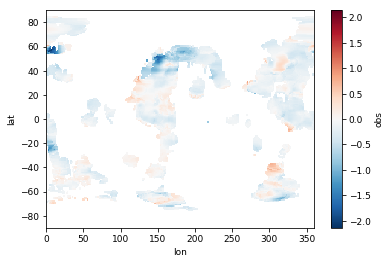

In [6]:
trend_map.obs.plot()

In [7]:
pentads = np.arange(1970,2015,5)
obs5 = obs.groupby_bins('time',pentads).mean(dim='time')
obs5['o2_std'] = obs.o2.groupby_bins('time',pentads).std(dim='time')
obs5['time'] = np.vstack((pentads[:-1],pentads[1:])).mean(axis=0)
obs5

<xarray.Dataset>
Dimensions:    (time: 8, time_bins: 8)
Coordinates:
  * time_bins  (time_bins) object (1970, 1975] (1975, 1980] (1980, 1985] ...
  * time       (time) float64 1.972e+03 1.978e+03 1.982e+03 1.988e+03 ...
Data variables:
    o2         (time_bins) float64 1.739 2.124 2.911 1.606 2.006 -0.234 ...
    o2_std     (time_bins) float64 1.512 1.733 1.708 2.314 2.895 2.522 1.729 ...

[-0.5, '', -0.4, '', -0.3, '', -0.2, '', -0.1, '', '0', '', 0.1, '', 0.2, '', 0.3, '', 0.4, '', 0.5]


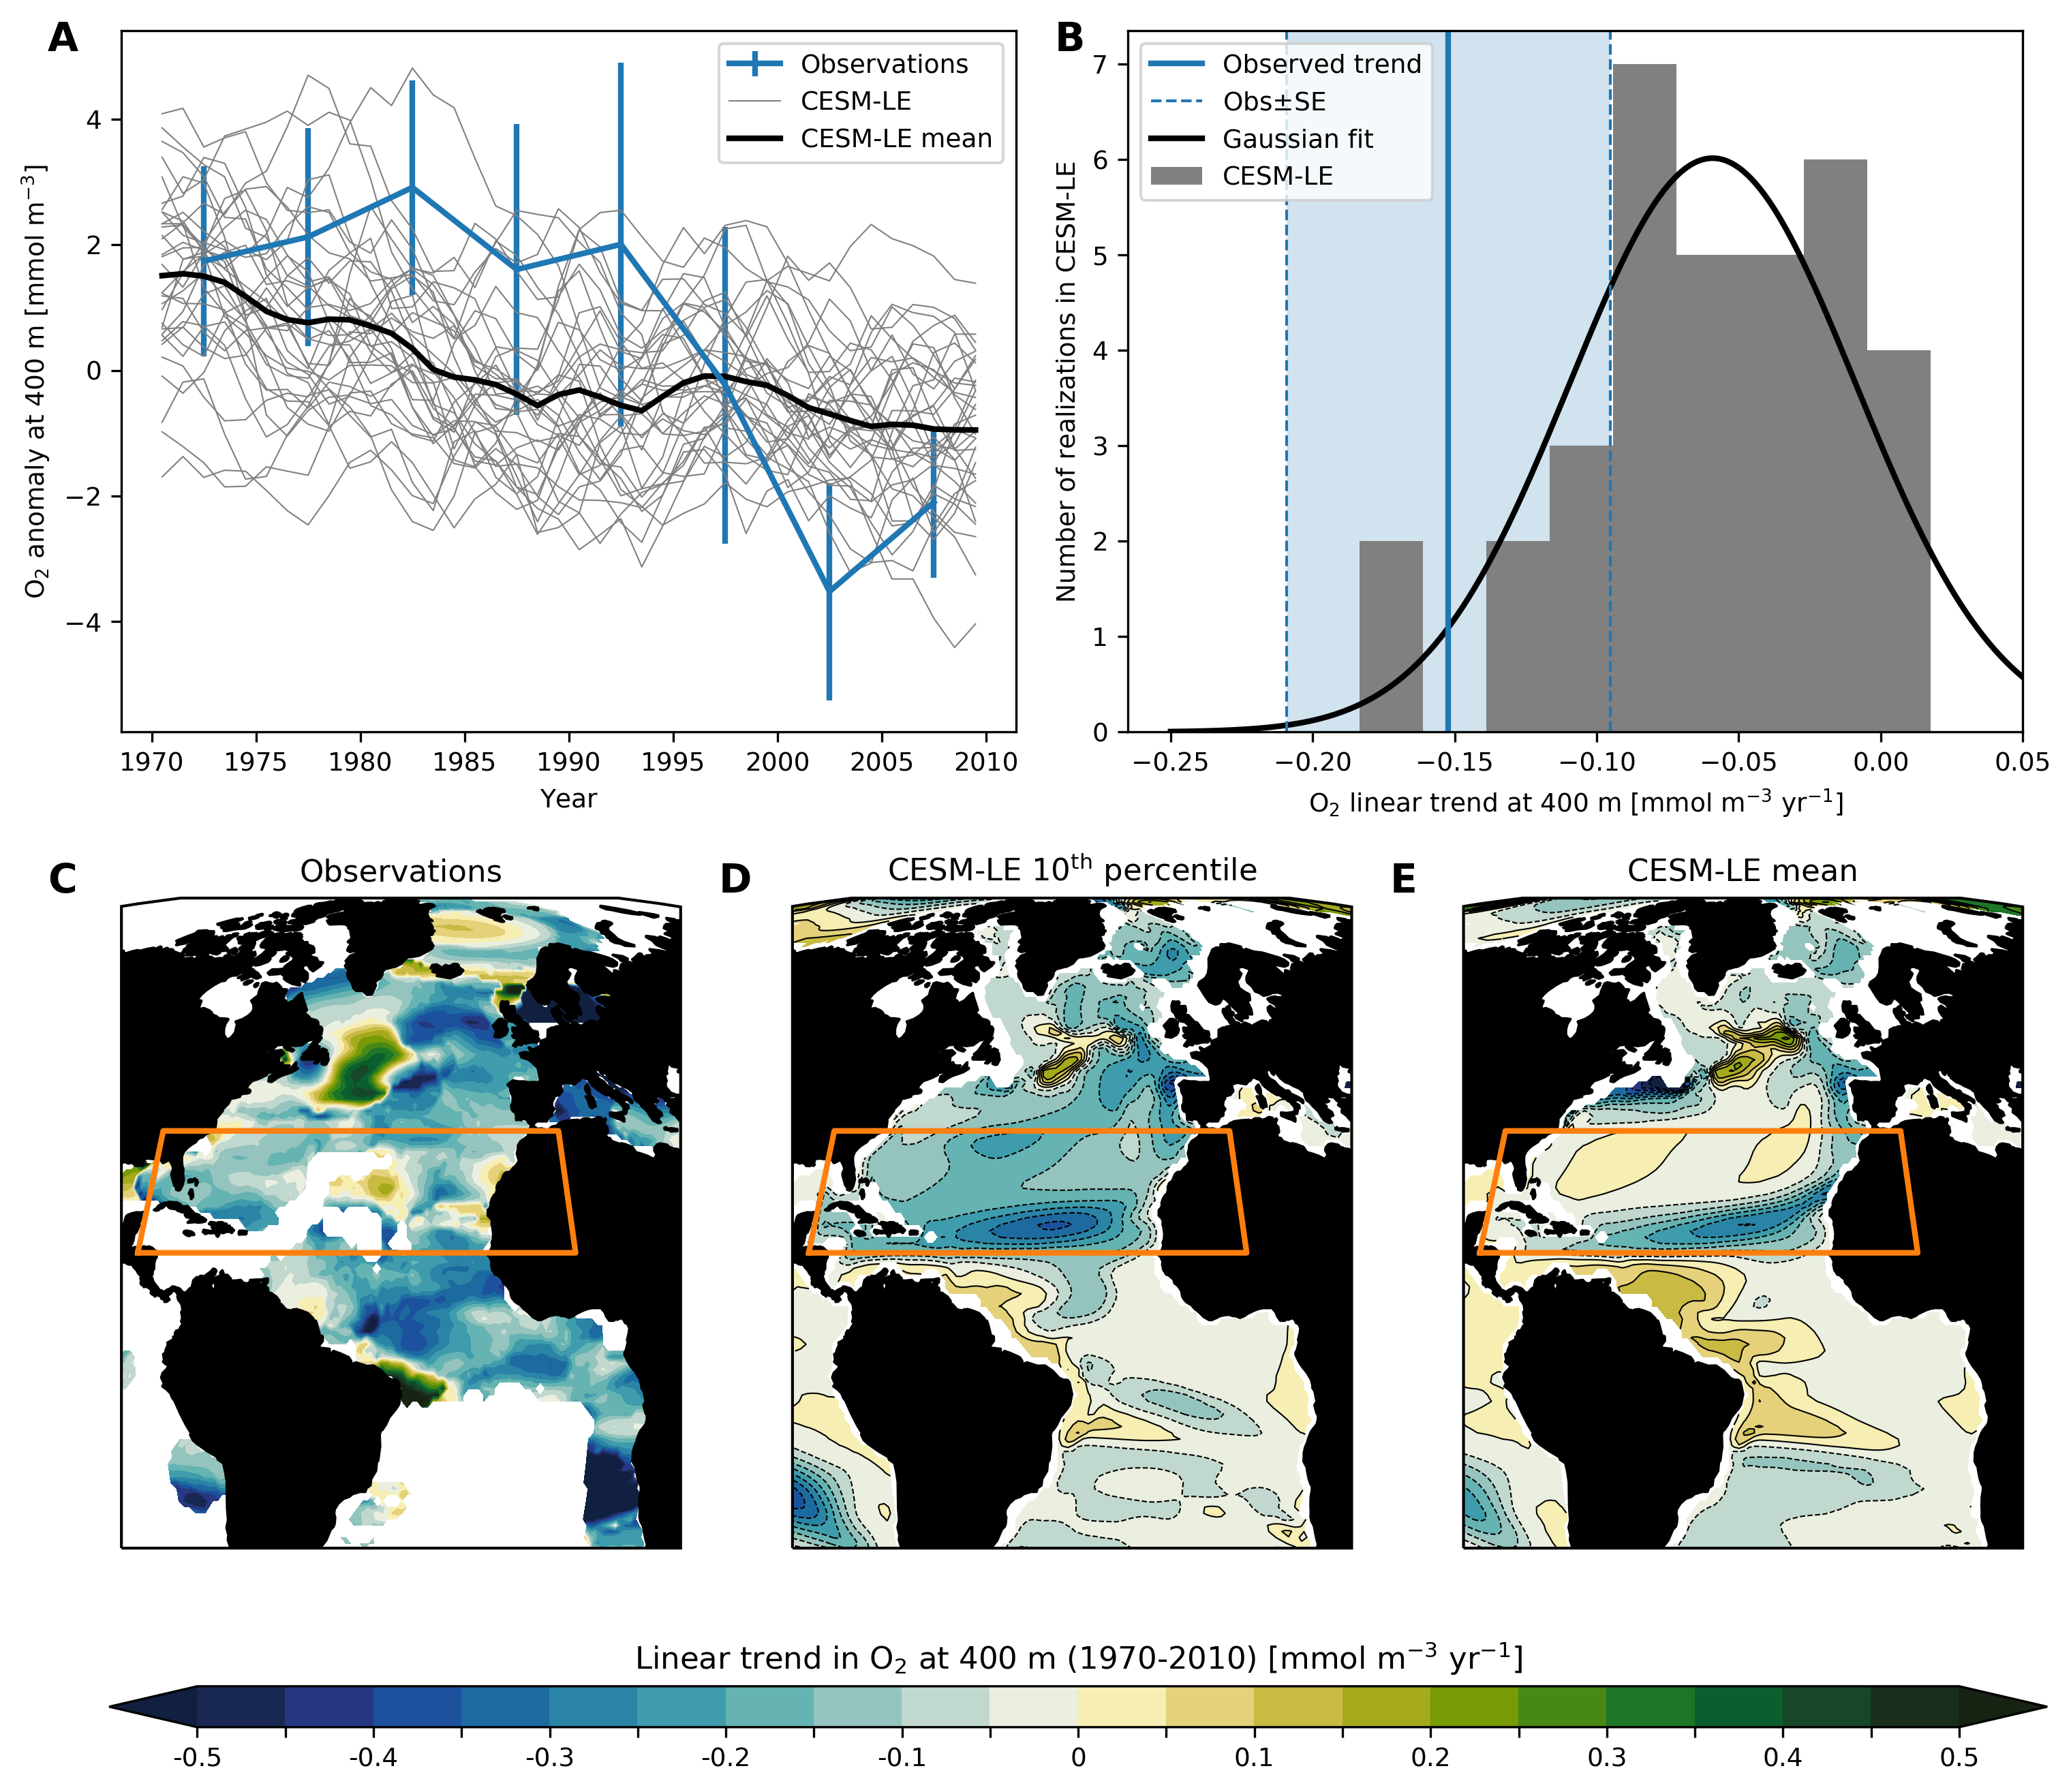

In [8]:
from cartopy.util import add_cyclic_point

plot_name = os.path.join(diro['fig'],'obs-cesm-stna-trends.pdf')

fig = plt.figure(dpi=300,figsize=(12,10),facecolor='w')
gs = gridspec.GridSpec(2,6)

#cesmplot = cesm_le.sel(basin='Global',depth=400)
#cesmplota = cesmplot.mean(dim='ens')

#------------------------------------------------------------------------------
#-- plot time series
#------------------------------------------------------------------------------

ax = fig.add_subplot(gs[0,0:3])

po = ax.errorbar(obs5.time,obs5.o2, yerr=obs5.o2_std,linewidth=2,
           label = 'Observations')

pe = ax.plot(cesm_o2.time,cesm_o2-cesm_o2.mean(),color='gray',linewidth=0.5,
       label='CESM-LE')
pa = ax.plot(cesm_o2.time,cesm_o2.mean(dim='ens')-cesm_o2.mean(),color='k',linewidth=2,
       label='CESM-LE mean')

ax.legend([po,pe[0],pa[0]],['Observations','CESM-LE','CESM-LE mean'])

ax.set_ylabel('O$_2$ anomaly at 400 m [mmol m$^{-3}$]')
ax.set_xlabel('Year')

#------------------------------------------------------------------------------
#-- plot hist
#------------------------------------------------------------------------------

ax = fig.add_subplot(gs[0,3:6])

n,bins,ph = ax.hist(trle,9,color='gray')

b = np.diff(bins)[0]
x = np.arange(-0.25,0.051,0.001)
s = trle.std().values
m = trle.mean().values

y = b * 34. / (s * np.sqrt(2.*np.pi)) * np.exp(-0.5*((x-m)/s)**2)

pg = ax.plot(x,y,color='k',linewidth=2.)

ylim = ax.get_ylim()

#------------------------------------------------------------------------------
#-- plot obs trend on hist
#------------------------------------------------------------------------------

x = np.arange(trobs-seobs,
              trobs+seobs+0.001,0.001)
ax.fill_between(x,ylim[0],ylim[1],alpha=0.2)
po = ax.axvline(trobs,linewidth=2.)

ps = ax.axvline(x[0],linestyle='--',linewidth=1)
ax.axvline(x[-1],linestyle='--',linewidth=1)
xlim = ax.get_xlim()

ax.set_xlim((xlim[0],0.05))
ax.set_ylim(ylim)

ax.set_ylabel('Number of realizations in CESM-LE')
ax.set_xlabel('O$_2$ linear trend at 400 m [mmol m$^{-3}$ yr$^{-1}$]')

ax.legend([po,ps,pg[0],ph[0]],['Observed trend','Obs$\pm$SE','Gaussian fit','CESM-LE'])

#------------------------------------------------------------------------------
#-- plot maps
#------------------------------------------------------------------------------
contour_spec = {'levels':np.arange(-0.5,0.55,0.05),'cmap':cmocean.cm.delta,'extend':'both'}

box_top = 35.
box_bot = 15.
x, y = [-87, -87, 0, 0, -87], [box_bot, box_top, box_top, box_bot, box_bot]

#------------------------------------------------------------------------------
#--- obs
#------------------------------------------------------------------------------
ax = fig.add_subplot(gs[1,0:2],projection=ccrs.Mollweide(central_longitude=-35.0))
ax.set_extent([-90,20,-20,80])
lon = trend_map.lon.values
lat = trend_map.lat.values
z = trend_map.obs.values
lon = np.where(lon<0.,lon+360.,lon)
I = np.argsort(lon)
lon = lon[I]
z = z[:,I]
z,lon = add_cyclic_point(z,coord=lon)

ax.contourf(lon,lat,z,transform=ccrs.PlateCarree(),**contour_spec) 
land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='face',
                                            facecolor='black'))



ax.plot(x, y, linewidth=2.,color='#ff7f0e', transform=ccrs.PlateCarree())
    
ax.set_title('Observations')

#------------------------------------------------------------------------------
#--- 10%
#------------------------------------------------------------------------------

ax = fig.add_subplot(gs[1,2:4],projection=ccrs.Mollweide(central_longitude=-35.0))
ax.set_extent([-90,20,-20,80])
lon = trend_map.lon.values

lat = trend_map.lat.values
z = trend_map.LE10.values
lon = np.where(lon<0.,lon+360.,lon)
I = np.argsort(lon)
lon = lon[I]
z = z[:,I]
z,lon = add_cyclic_point(z,coord=lon)

ax.contourf(lon,lat,z,transform=ccrs.PlateCarree(),**contour_spec) 
ax.contour(lon,lat,z,transform=ccrs.PlateCarree(),
           colors='k',
           levels = contour_spec['levels'],
           linewidths = 0.5)

land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='face',
                                            facecolor='black'))

ax.plot(x, y, linewidth=2.,color='#ff7f0e', transform=ccrs.PlateCarree())

ax.set_title('CESM-LE 10$^{th}$ percentile')

#------------------------------------------------------------------------------
#--- mean
#------------------------------------------------------------------------------

ax = fig.add_subplot(gs[1,4:6],projection=ccrs.Mollweide(central_longitude=-35.0))
ax.set_extent([-90,20,-20,80])
lon = trend_map.lon.values
lat = trend_map.lat.values
z = trend_map.LE.mean(dim='ens').values
lon = np.where(lon<0.,lon+360.,lon)
I = np.argsort(lon)
lon = lon[I]
z = z[:,I]
z,lon = add_cyclic_point(z,coord=lon)

cf = ax.contourf(lon,lat,z,transform=ccrs.PlateCarree(),**contour_spec)
ax.contour(lon,lat,z,transform=ccrs.PlateCarree(),
           colors='k',
           levels = contour_spec['levels'],
           linewidths = 0.5)

land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='face',
                                            facecolor='black'))

ax.plot(x, y, linewidth=2.,color='#ff7f0e', transform=ccrs.PlateCarree())

ax.set_title('CESM-LE mean')

#------------------------------------------------------------------------------
#--- colorbar and labels
#------------------------------------------------------------------------------

gs.update(wspace=0.5)

cax = fig.add_axes([0.12, 0.05, 0.79, 0.02])
cb = fig.colorbar(cf,cax=cax,
                  ticks = contour_spec['levels'],
                  orientation = 'horizontal')   
cax.set_title('Linear trend in O$_2$ at 400 m (1970-2010) [mmol m$^{-3}$ yr$^{-1}$]',loc='center')

t = []
for i,x in enumerate(contour_spec['levels']):
    if i%2 == 0:
        if np.abs(x) < 1e-10:
            t.append('0')
        else:
            t.append(plot_tools.contour_label_format(np.round(x,1)))
    else:
        t.append('')
print t
cb.ax.set_xticklabels(t)

alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(fig.get_axes()):
    if i == 5: break
    p = axi.get_position()
    y = p.y1-0.01
    x = p.x0-0.03
    fig.text(x,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold')

plt.savefig(plot_name,dpi=300,bbox_inches='tight')    